# 價值型低估值策略簡介（參考查爾士．布蘭帝選股邏輯）

查爾士．布蘭帝（Charles Brandes）為班傑明．葛拉漢的傳人之一，自 1974 年創立 Brandes Investment Partners 起，將資產管理規模從 1.3 億美元擴大至逾 750 億美元，旗下基金表現長期穩健。

本策略參考布蘭帝的價值投資核心精神：**以具安全邊際、財務穩健、估值合理的企業作為長期投資標的**，並排除對未來的主觀預測，透過歷史資料量化其投資原則，在台股市場進行驗證。

---

## 選股條件（可量化指標）

1. **最近一季負債淨值比 < 40%**  
   - 表示企業主要以自有資本營運，債務壓力較低，抗風險能力較高。

2. **董監事持股比 > 市場平均**  
   - 管理階層與股東利益綁定，代表經營團隊對企業前景具信心。

3. **近四季本益比（P/E） < 市場平均**  
   - 表示該公司估值低，尚未被市場高度定價，具有潛在上漲空間。

4. **股價／近四季現金流量比（P/CF） < 市場平均**  
   - 反映以較低價格取得穩定現金流，風險相對較小。

5. **最近一季股價／淨值比（P/B） < 市場平均**  
   - 股價相對帳面價值被低估，具備一定安全邊際。

6. **最近一季股價／淨值比（P/B） < 1.0**  
   - 當市價低於帳面價值時，具備更強的「清算價保護」概念。

---

## 回測設計概要

- **投資標的**：台灣上市櫃公司  
- **資料期間**：2013 年起至今，涵蓋股價、財報、董監持股等資訊  
- **回測期間**：2020/01/01 至 2025/04/21  
- **篩選條件**：每次篩選時需同時滿足上述六項條件  
- **資金配置**：等權重分配至所有篩選出之股票  
- **再平衡頻率**：每 60 個交易日（約每季一次）

---

## 策略特點

- **安全邊際為核心原則**：每檔股票均具備帳面價值保護與評價低估特徵  
- **排除未來預測成分**：僅依過去可驗證的會計與市場資料進行判斷  
- **強調財務穩健與經營誠信**：透過負債比與董監事持股過濾風險企業  
- **配置單純、邏輯明確**：不依賴預測或模型，便於實務應用與檢驗  
- **再平衡週期長、交易成本低**：每 60 天調整一次，符合價值投資邏輯

---

本策略旨在驗證布蘭帝價值投資思想在台灣股市中的可行性，透過「低估值＋穩健財務＋誠信經營」三重條件，尋找長期被低估但具潛力回升的標的，並建構出具有可持續性的量化價值投資架構。


In [ ]:
import pandas as pd
import numpy as np
import tejapi
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
tej_key ='your key'
tejapi.ApiConfig.api_key = tej_key
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY'] = tej_key

from zipline.sources.TEJ_Api_Data import get_universe
import TejToolAPI
from zipline.data.run_ingest import simple_ingest
from zipline.api import set_slippage, set_commission, set_benchmark,  symbol,  record, order_target_percent
from zipline.finance import commission, slippage
from zipline import run_algorithm
from scipy.optimize import minimize

In [2]:
start_date = '2010-01-01'; end_date = '2025-04-21'

pool = get_universe(start = start_date,
                      end = end_date,
                      mkt_bd_e = ['TSE', 'OTC'],
                      stktp_e = 'Common Stock',
                      main_ind_e = 'General Industry')

columns = ['coid','bstl', 'bsse', 'fld005', 'close_d', 'per', 'pbr_tej', 'shares', 'cscfo', 'cscfi', 'cscff']

start_dt = pd.Timestamp(start_date, tz = 'UTC')
end_dt = pd.Timestamp(end_date, tz = "UTC")

data_use = TejToolAPI.get_history_data(start = start_dt,
                                    end = end_dt,
                                    ticker = pool,
                                    fin_type = 'Q', # 為累計資料
                                    columns = columns,
                                    transfer_to_chinese = False)

Currently used TEJ API key call quota 1219/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 116803504/9223372036854775807 (0.0%)
Currently used TEJ API key call quota 1337/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 123177192/9223372036854775807 (0.0%)


In [3]:
# 確保時間格式正確
data_use['mdate'] = pd.to_datetime(data_use['mdate'])

# 計算 Total_cashflow
data_use['Total_cashflow'] = data_use['Cash_Flow_from_Operating_Activities_Q']

# 排序
data_use = data_use.sort_values(['coid', 'mdate'])

# 轉成季資料：每股公司取每季最後一筆
df_q = data_use.set_index('mdate').groupby('coid', group_keys=False).resample('Q').last().reset_index()

# 計算近四季平均本益比
df_q['PER_4Q_avg'] = df_q.groupby('coid')['PER_TWSE'].transform(lambda x: x.rolling(4, min_periods=4).mean())

# 計算近四季總現金流
df_q['Cashflow_4Q_sum'] = df_q.groupby('coid')['Total_cashflow'].transform(lambda x: x.rolling(4, min_periods=4).sum())

# 計算「股價 / 現金流」：若現金流為 0，則設為 NaN 避免除以 0
df_q['Price_to_CF'] = (df_q['Close'] * df_q['Issue_Shares_1000_Shares']) / df_q['Cashflow_4Q_sum'].replace(0, np.nan)

# 市場平均本益比 & 市場平均 Price_to_CF
df_q['Market_PER_avg'] = df_q.groupby('mdate')['PER_TWSE'].transform('mean')
df_q['Market_PCF_avg'] = df_q.groupby('mdate')['Price_to_CF'].transform('mean')

# 判斷是否低於市場平均
df_q['PER_below_market'] = df_q['PER_4Q_avg'] < df_q['Market_PER_avg']
df_q['PCF_below_market'] = df_q['Price_to_CF'] < df_q['Market_PCF_avg']

# 確保排序
data_use = data_use.sort_values(['coid', 'mdate'])
df_q = df_q.sort_values(['coid', 'mdate'])

# 用 merge_asof 把季資料合併回每日
result_list = []

for coid, df_daily_group in data_use.groupby('coid'):
    df_q_group = df_q[df_q['coid'] == coid]

    merged = pd.merge_asof(
        df_daily_group,
        df_q_group[['mdate', 'PER_below_market', 'PCF_below_market']],
        on='mdate',
        direction='backward'
    )
    result_list.append(merged)

# 合併所有公司
data_final = pd.concat(result_list).sort_values(['coid', 'mdate']).reset_index(drop=True)


In [4]:
def compute_stock(date, data):
    df = data[data['mdate'] == pd.to_datetime(date)].reset_index(drop = True)

    df['debt_equity_ratio'] = df['Total_Liabilities_Q'] / df['Total_Equity_Q']
    set_1 = set(df[df['debt_equity_ratio'] < .4]['coid'])

    Director_avg = df['Director_and_Supervisor_Holdings_Percentage'].mean()
    set_2 = set(df[df['Director_and_Supervisor_Holdings_Percentage'] > Director_avg]['coid'])

    set_3 = set(df[df['PER_below_market'] == True]['coid'])

    set_4 = set(df[df['PCF_below_market'] == True]['coid'])

    PBR_avg = df['PBR_TEJ'].mean()
    set_5 = set(df[df['PBR_TEJ'] < PBR_avg]['coid'])

    set_6 = set(df[df['PBR_TEJ'] < 1.0]['coid'])

    tickers = list(set_1 & set_2 & set_5 & set_6 & set_3 & set_4)


    return tickers

In [5]:
pools = pool + ['IR0001']

start_ingest = start_date.replace('-', '')
end_ingest = end_date.replace('-', '')

print(f'開始匯入回測資料')
simple_ingest(name = 'tquant' , tickers = pools , start_date = start_ingest , end_date = end_ingest)
print(f'結束匯入回測資料')

開始匯入回測資料
Now ingesting data.


[2025-06-06 04:03:14.187311] INFO: zipline.data.bundles.core: Ingesting tquant.


Merging daily equity files:
Currently used TEJ API key call quota 1343/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 134361206/9223372036854775807 (0.0%)


[2025-06-06 04:07:27.213003] INFO: zipline.data.bundles.core: Ingest tquant successfully.


End of ingesting tquant.
Please call function `get_bundle(start_dt = pd.Timestamp('20100101', tz = 'utc'),end_dt = pd.Timestamp('20250421' ,tz = 'utc'))` in `zipline.data.data_portal` to check data.
Currently used TEJ API key call quota 1343/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 134361206/9223372036854775807 (0.0%)
結束匯入回測資料


In [6]:
def initialize(context):
    set_slippage(slippage.VolumeShareSlippage(volume_limit=1, price_impact=0.01))
    set_commission(commission.Custom_TW_Commission())
    set_benchmark(symbol('IR0001'))

    context.i = 0
    context.state = False
    context.order_tickers = []
    context.last_tickers = []
    


def handle_data_1(context, data, rebalance = 60):
    # 避免前視偏誤，在篩選股票下一交易日下單
    if context.state == True:

        for i in context.last_tickers:
            if i not in context.order_tickers:
                order_target_percent(symbol(i), 0)


        for i in context.order_tickers:
            order_target_percent(symbol(i), 1 / len(context.order_tickers))

            curr = data.current(symbol(i), 'price')
            record(price = curr, days = context.i)

        print(f"下單日期：{data.current_dt.date()}, 擇股股票數量：{len(context.order_tickers)}, Leverage: {context.account.leverage}")


        context.last_tickers = context.order_tickers.copy()
        context.state = False

    backtest_date = data.current_dt.date()

    if context.i % rebalance == 0:
        context.state = True
        context.order_tickers = compute_stock(date = backtest_date, data = data_final)


    record(Leverage = context.account.leverage)
    if context.account.leverage > 1.2:
        print(f'{data.current_dt.date()}: Over Leverage, Leverage: {context.account.leverage}')
        for i in context.order_tickers:
            order_target_percent(symbol(i), 1 / len(context.order_tickers))

    context.i += 1


In [7]:
def test(context, data):
    if context.i == 0:
        order_target_percent(symbol('IR0001'), 1.0)

    context.i += 1


def ana_test(context, perf):
    pass

下單日期：2020-01-03, 擇股股票數量：20, Leverage: 0.0
下單日期：2020-04-10, 擇股股票數量：28, Leverage: 0.9462527312299922
下單日期：2020-07-08, 擇股股票數量：19, Leverage: 0.9961893163396448
下單日期：2020-09-30, 擇股股票數量：17, Leverage: 0.9776219546095151
下單日期：2020-12-28, 擇股股票數量：17, Leverage: 0.997589164043473
下單日期：2021-04-06, 擇股股票數量：13, Leverage: 0.9958934747480133
下單日期：2021-07-01, 擇股股票數量：15, Leverage: 0.9946169218153786
下單日期：2021-09-27, 擇股股票數量：14, Leverage: 0.9805785050680207
下單日期：2021-12-21, 擇股股票數量：11, Leverage: 0.988583515795348
下單日期：2022-03-28, 擇股股票數量：14, Leverage: 0.9907015492141674
下單日期：2022-06-24, 擇股股票數量：19, Leverage: 1.0038749028345468
下單日期：2022-09-19, 擇股股票數量：7, Leverage: 0.9559949177034098
下單日期：2022-12-13, 擇股股票數量：22, Leverage: 0.9933241127831431
下單日期：2023-03-22, 擇股股票數量：9, Leverage: 1.0052888118243835
下單日期：2023-06-20, 擇股股票數量：17, Leverage: 1.0135327848248266
下單日期：2023-09-15, 擇股股票數量：3, Leverage: 0.9779591486168348
下單日期：2023-12-13, 擇股股票數量：4, Leverage: 1.0218864130368177
下單日期：2024-03-19, 擇股股票數量：2, Leverage: 1.0072065183388

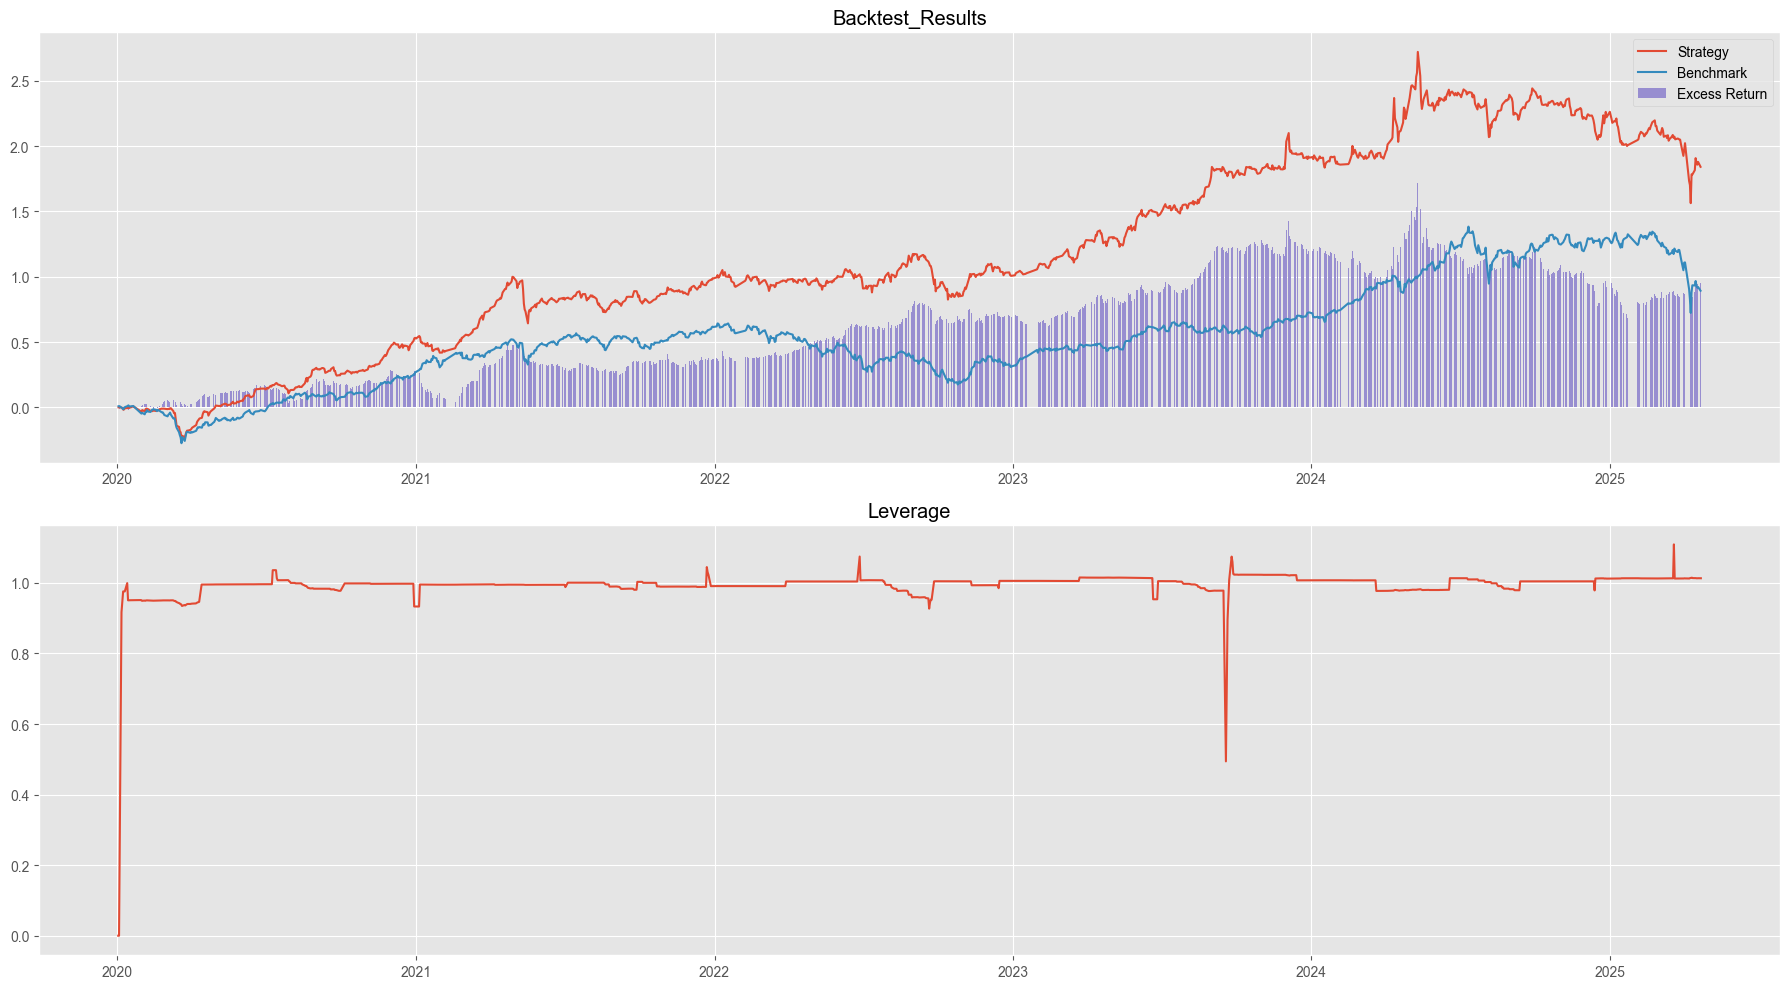

In [10]:
def analyze(context, perf):
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), sharex=False)
        plt.style.use('ggplot')
        axes[0].plot(perf.index, perf['algorithm_period_return'], label = 'Strategy')
        axes[0].plot(perf.index, perf['benchmark_period_return'], label = 'Benchmark')
        axes[0].bar(perf.index, perf['algorithm_period_return'] - perf['benchmark_period_return'], label = 'Excess Return', color = '#988ED0')
        axes[0].set_title(f"Backtest_Results")
        axes[0].legend()

        axes[1].plot(perf.index, perf['Leverage'], label = 'Leverage')
        axes[1].set_title(f"Leverage")
        axes[1].legend

        plt.tight_layout()
        plt.show()

results = run_algorithm(
            start = pd.Timestamp('2020-01-01', tz = 'utc'),
            end = pd.Timestamp('2025-04-21', tz = 'utc'),
            initialize = initialize,
            handle_data = handle_data_1,
            analyze = analyze,
            bundle = 'tquant',
            capital_base = 1e6)

## 策略績效分析

策略年化報酬率達 **23.75%**，同期大盤年化報酬率僅 **15%**，明顯**超越指數表現**。

- **夏普比率**為 **1.15**  
  → 表示在扣除無風險報酬後，每承擔一單位風險可獲取 1.15 單位的超額報酬，風險調整後報酬具吸引力。

- **CAPM 回歸結果**：  
  - **Alpha = 0.15**（即年化 **15%**）  
    → 代表策略長期穩定產生超額收益，具選股能力。  
  - **Beta = 0.61**  
    → 組合對大盤波動的敏感度僅一半左右，顯示**良好的分散與抗震能力**。

---

## 報酬曲線觀察與市場背景解讀

- **2020 年底至 2021 年 Q1**：  
  策略表現明顯優於大盤，主因當時**高品質價值股（如航運、傳產）出現估值修復**，符合布蘭帝「低估資產終將回歸合理價值」的理念。

- **2023 年初至 2024 年初的牛市階段**：  
  策略持續領先指數，價值股隨整體市場上行而受益，進一步驗證**在牛市中，具備安全邊際的價值投資策略同樣具備強大優勢**。


> 整體而言，本策略在多頭市場中不僅能跟上漲勢，還能透過精準選股拉開與大盤的差距；同時具備低 Beta 結構，在震盪市況中提供更佳的資產配置品質。

---

## 回撤分析與市場解讀

策略歷經 **COVID-19 初期、高估值修正、升息壓力** 等多次市場動盪，整體抗震表現穩定：

- **五大回撤峰值**介於約 **–10% 至 –30%** 之間  
- 多數回撤能在 **3 至 6 個月內收斂**，顯示市場修復力與策略回彈速度良好

---

### 特殊觀察：2024–2025 年回撤段落

- 此段回撤相較歷史更大，發生於**市場牛市的末升段**
- 該時期市場風險意識降低、資金追逐高估成長股，使**價值股機會相對減少**
- 對價值投資者而言，此階段更適合：
  - **逢高減碼**部分標的  
  - **換手至現金或短天期債券**，提高組合防禦性

---

> 結論：策略在多數市場環境中皆具備穩健回撤控制能力，但面對資金過度偏好成長與高估的階段，應強化風險調節與資產轉換機制，以維持整體績效穩定。


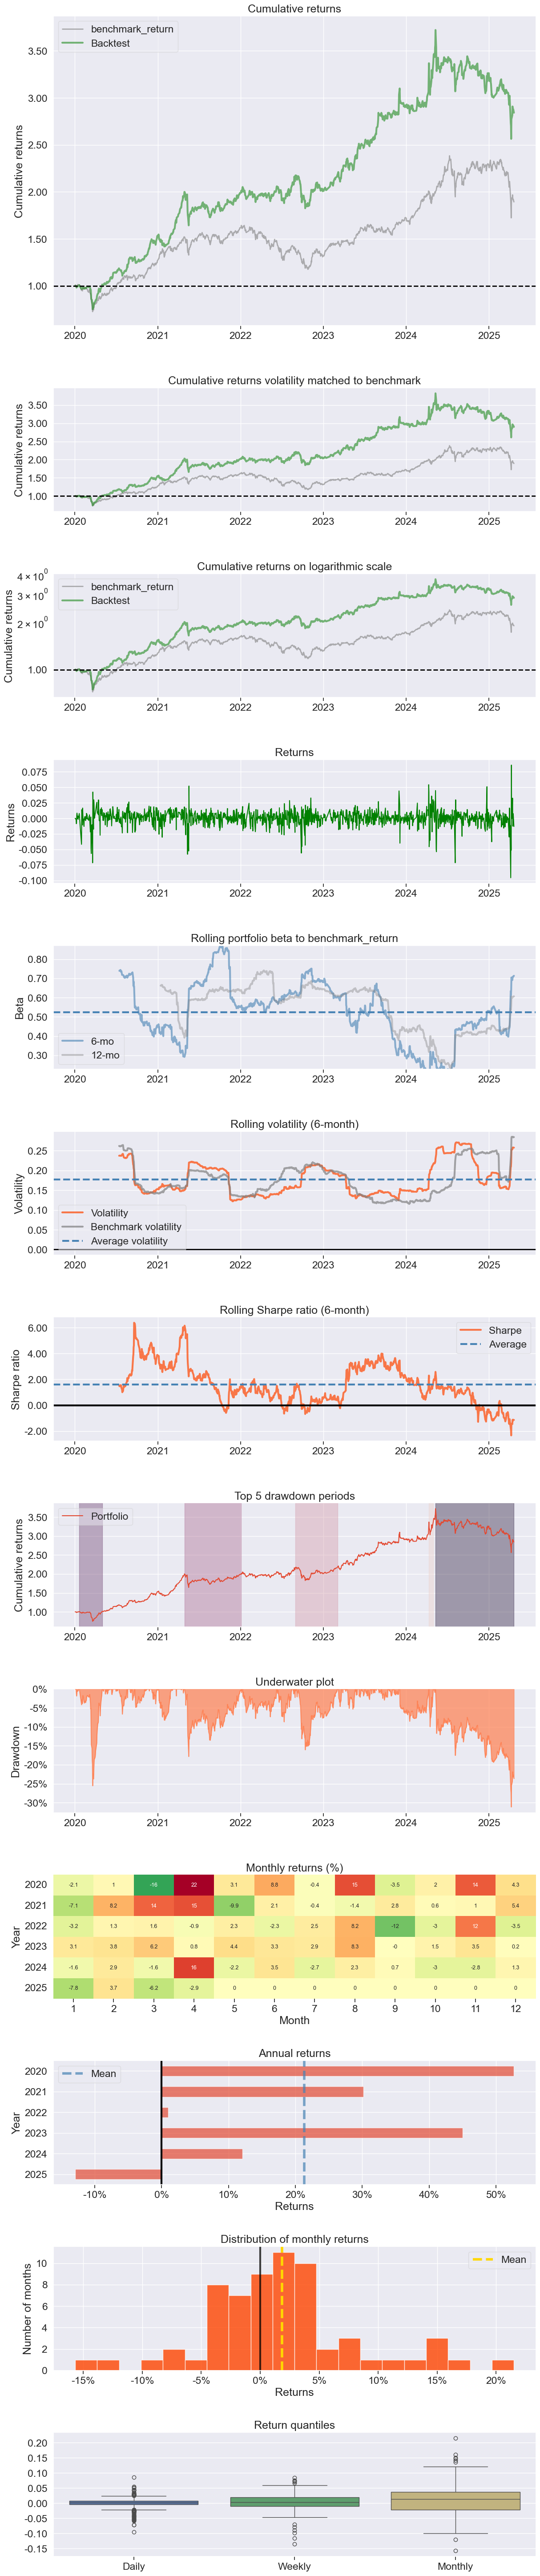

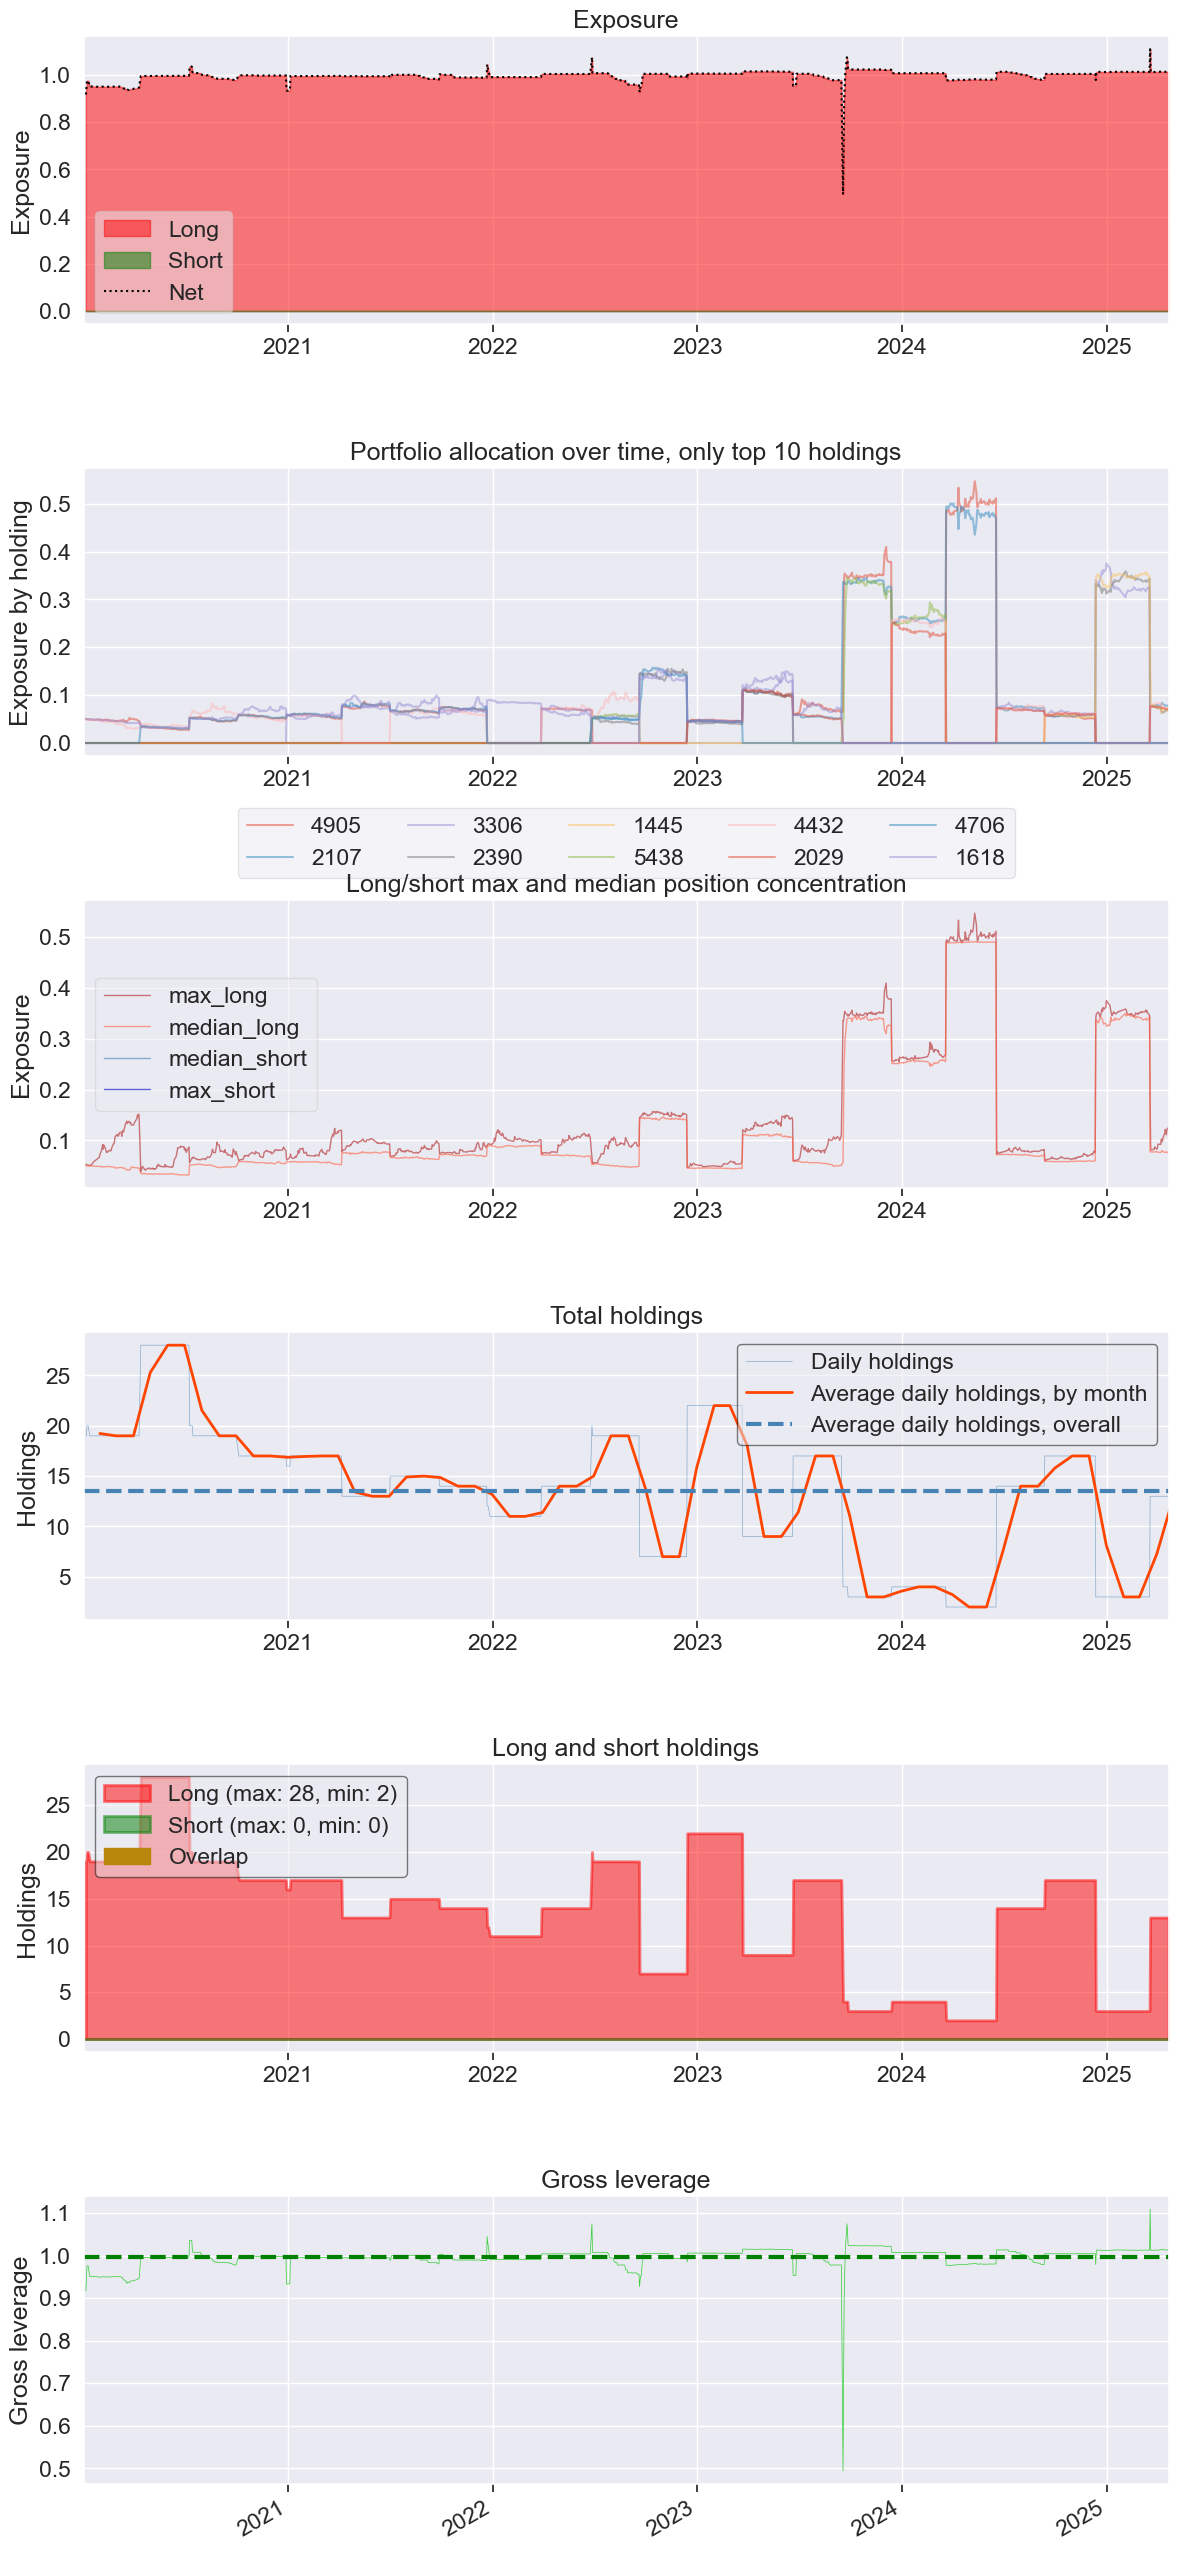

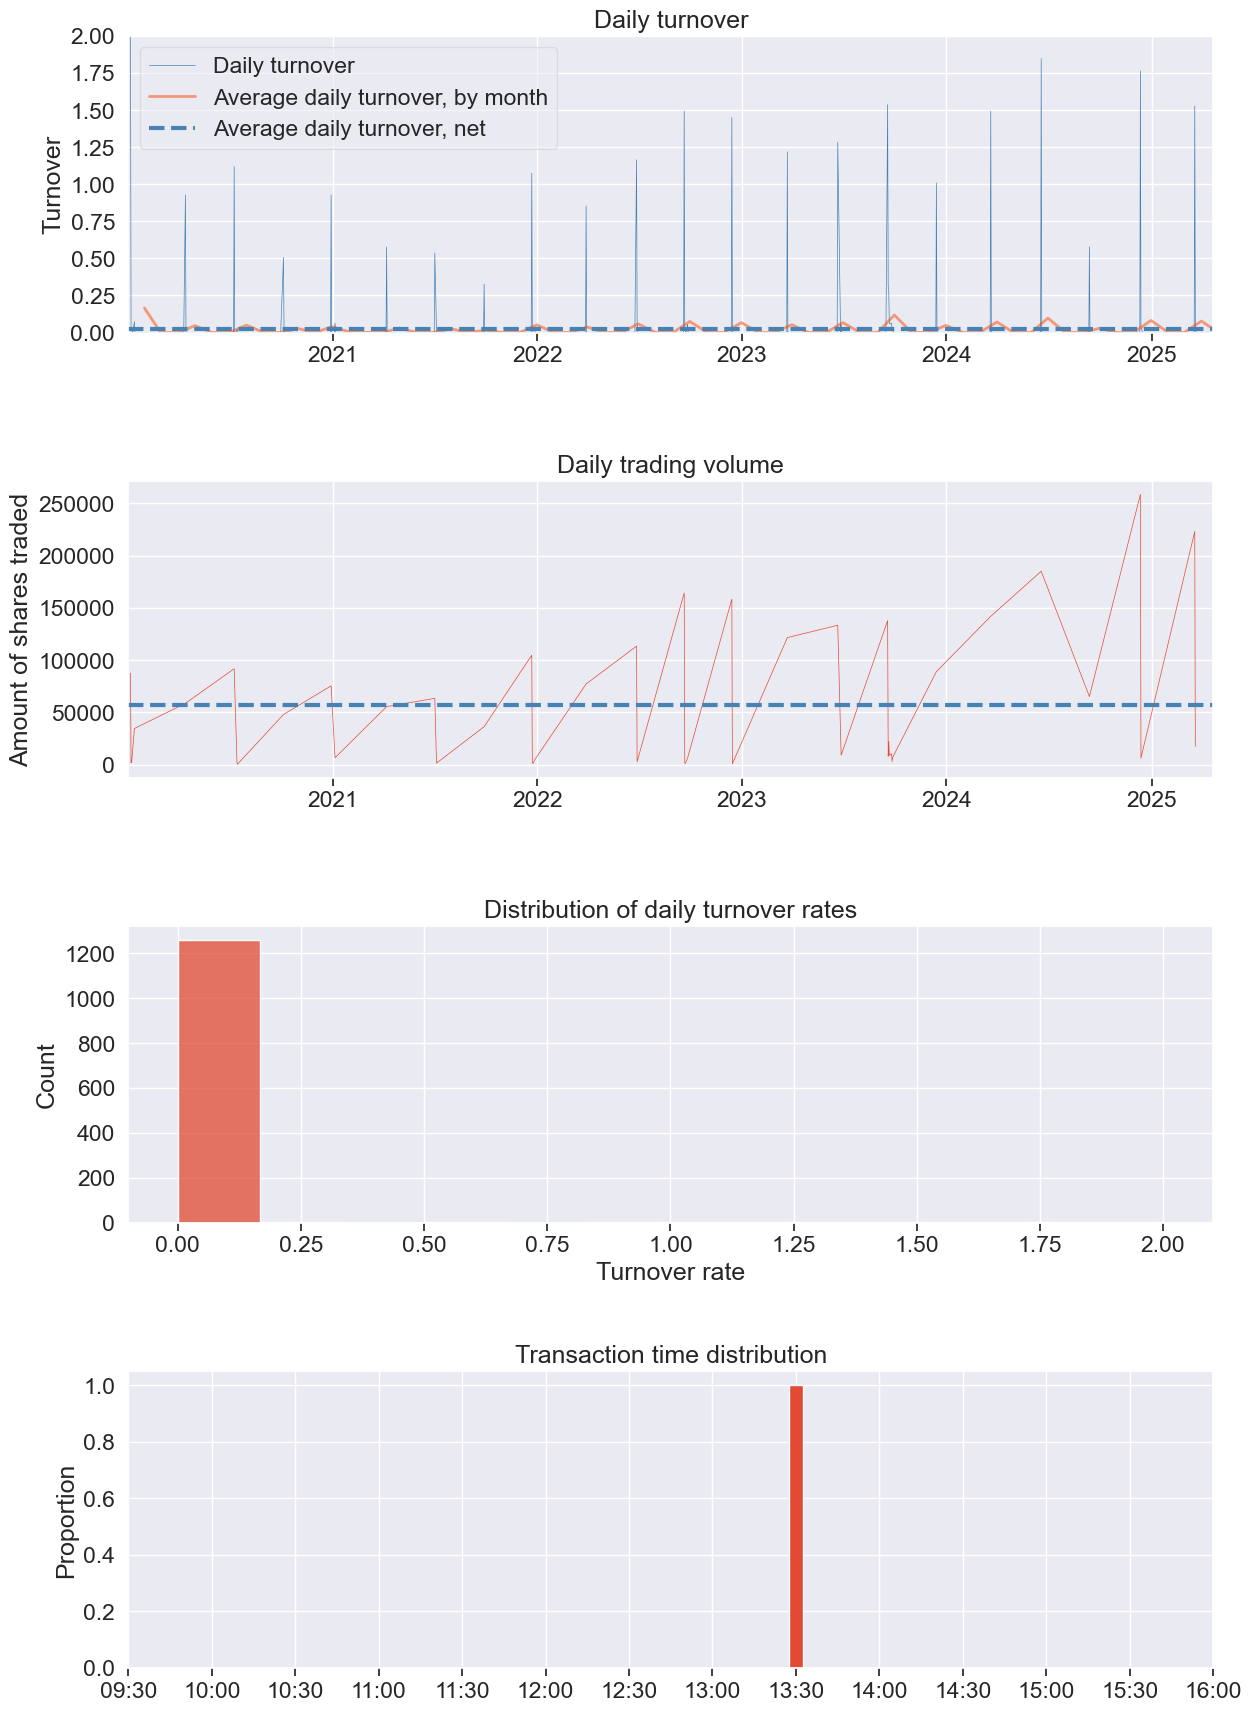

In [11]:
import pyfolio
from pyfolio.utils import extract_rets_pos_txn_from_zipline
plt.rcParams['font.sans-serif'] = ['Arial', 'Noto Sans CJK TC', 'SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return
pyfolio.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )